# Fira Code

In [23]:
import os
import pathlib
import shutil
import tensorflow as tf
from tensorflow import keras
from keras import regularizers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [24]:
def create_label_dir(df):
    class_names = np.sort(df['label'].unique())
    number_of_classes = len(class_names)

    if not os.path.exists('../gdsc-ai-challenge/train'):
        return class_names, number_of_classes

    for class_name in class_names:
        dir = pathlib.Path('../gdsc-ai-challenge/train/' + class_name)
        if dir.exists():
            continue
        else:
            dir.mkdir()
    
    return class_names, number_of_classes

def sort_data(df):
    if not os.path.exists('../gdsc-ai-challenge/train'):
        return
        
    for image_dir in [str(img) for img in list(pathlib.Path('../gdsc-ai-challenge/train/train').glob('*.png'))]:
        id = int(image_dir.removeprefix('../gdsc-ai-challenge/train/train/').removesuffix('.png'))
        label = df['label'][id - 1]
        dest_path = os.path.join('../gdsc-ai-challenge/train', label, str(id) + '.png')
        shutil.move(image_dir, dest_path)

In [25]:
label_df = pd.read_csv('../gdsc-ai-challenge/trainLabels.csv')

class_names, number_of_classes = create_label_dir(label_df)
sort_data(label_df)

In [26]:
builder = tf.keras.utils.image_dataset_from_directory(
    '../gdsc-ai-challenge/train',
    color_mode='grayscale',
    batch_size=None,
    image_size=(32,32),
    seed=42
)

Found 50000 files belonging to 10 classes.


In [27]:
def get_dataset_partitions_tf(ds, ds_size, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=42)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

def configure_for_performance(ds, batch_size=32):
    ds = ds.cache()
    ds = ds.shuffle(buffer_size=1000)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=tf.data.AUTOTUNE)
    return ds

In [28]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(builder, 50000, train_split=0.7, val_split=0.2, test_split=0.1)

normalization_layer = tf.keras.layers.Rescaling(1./255)

train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))
test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))

train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)
test_ds = configure_for_performance(test_ds)

In [29]:
model = keras.models.Sequential([
    keras.layers.Input((32,32,1)),
    keras.layers.Conv2D(32, (5,5), padding='same',
                        kernel_regularizer=regularizers.l2(1e-3),
                        activity_regularizer=regularizers.l2(1e-3),
                        kernel_initializer='he_normal',
                        activation='elu'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(32, (5,5), padding='same',
                        kernel_regularizer=regularizers.l2(1e-3),
                        activity_regularizer=regularizers.l2(1e-3),
                        kernel_initializer='he_normal',
                        activation='elu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(pool_size=(2,2)),

    keras.layers.Conv2D(64, (3,3), padding='same',
                        kernel_regularizer=regularizers.l2(1e-3),
                        activity_regularizer=regularizers.l2(1e-3),
                        kernel_initializer='he_normal',
                        activation='elu'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(64, (3,3), padding='same',
                        kernel_regularizer=regularizers.l2(1e-3),
                        activity_regularizer=regularizers.l2(1e-3),
                        kernel_initializer='he_normal',
                        activation='elu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(pool_size=(2,2)),
    keras.layers.Dropout(0.1),

    keras.layers.Conv2D(128, (3,3), padding='same',
                        kernel_regularizer=regularizers.l2(1e-3),
                        activity_regularizer=regularizers.l2(1e-3),
                        kernel_initializer='he_normal',
                        activation='elu'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(128, (3,3), padding='same',
                        kernel_regularizer=regularizers.l2(1e-3),
                        activity_regularizer=regularizers.l2(1e-3),
                        kernel_initializer='he_normal',
                        activation='elu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(pool_size=(2,2)),
    keras.layers.Dropout(0.2),

    keras.layers.Flatten(),
    keras.layers.Dense(64, activation='elu',
                       kernel_regularizer=regularizers.l2(1e-3),
                       activity_regularizer=regularizers.l2(1e-3)),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(64, activation='elu',
                       kernel_regularizer=regularizers.l2(1e-3),
                       activity_regularizer=regularizers.l2(1e-3)),
    keras.layers.Dense(number_of_classes, activation='softmax')
])

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0003),
                                              loss='sparse_categorical_crossentropy',
                                              metrics=['accuracy'])

In [30]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 32, 32, 32)        832       
                                                                 
 batch_normalization_12 (Bat  (None, 32, 32, 32)       128       
 chNormalization)                                                
                                                                 
 conv2d_13 (Conv2D)          (None, 32, 32, 32)        25632     
                                                                 
 batch_normalization_13 (Bat  (None, 32, 32, 32)       128       
 chNormalization)                                                
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                      

In [31]:
class stopCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}) :
        if (logs.get('accuracy') >= 0.999 and 
            logs.get('val_accuracy') >= 0.999) :
            print('\nReached 99.9% accuracy so stopping training')
            self.model.stop_training = True

In [32]:
callback = stopCallback()

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath='../Model/aiseries/version1.hdf5',
                                                               monitor='val_loss',
                                                               mode='min',
                                                               save_best_only=True)

history = model.fit(train_ds, 
                    epochs=30, 
                    callbacks=[callback, model_checkpoint_callback], 
                    validation_data=val_ds)

Epoch 1/30


2022-03-14 18:06:03.764290: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1094/1094 [==============================] - ETA: 0s - loss: 21.3249 - accuracy: 0.2311

2022-03-14 18:07:13.084666: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1094/1094 [==============================] - 80s 72ms/step - loss: 21.3249 - accuracy: 0.2311 - val_loss: 9.1575 - val_accuracy: 0.3092
Epoch 2/30
1094/1094 [==============================] - 75s 69ms/step - loss: 7.8489 - accuracy: 0.3283 - val_loss: 6.1199 - val_accuracy: 0.3507
Epoch 3/30
1094/1094 [==============================] - 77s 71ms/step - loss: 5.5270 - accuracy: 0.4047 - val_loss: 4.7613 - val_accuracy: 0.4143
Epoch 4/30
1094/1094 [==============================] - 76s 69ms/step - loss: 4.3272 - accuracy: 0.4554 - val_loss: 3.7687 - val_accuracy: 0.4813
Epoch 5/30
1094/1094 [==============================] - 79s 72ms/step - loss: 3.5589 - accuracy: 0.4909 - val_loss: 3.1490 - val_accuracy: 0.5157
Epoch 6/30
1094/1094 [==============================] - 78s 71ms/step - loss: 3.0475 - accuracy: 0.5148 - val_loss: 2.9058 - val_accuracy: 0.5059
Epoch 7/30
1094/1094 [==============================] - 83s 76ms/step - loss: 2.6313 - accuracy: 0.5430 - val_loss: 2.5207 - val_accur

In [33]:
model.evaluate(test_ds)

157/157 [==============================] - 7s 33ms/step - loss: 1.3530 - accuracy: 0.6838


[1.3530101776123047, 0.6838000416755676]

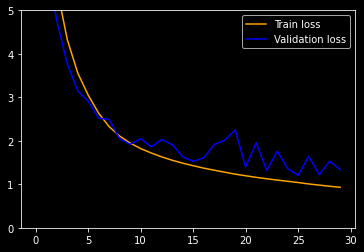

In [35]:
plt.plot(history.history['loss'], color='orange', label='Train loss')
plt.plot(history.history['val_loss'], color='blue', label='Validation loss')
plt.ylim((0, 5))
plt.legend()
plt.show()